# Necessary Packages and Imports

In [1]:
import json
import math
import os
import pickle
import random
from collections import Counter

import nltk
import pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from IPython.display import Image as DisplayImage
from PIL import Image
from torch.nn.utils.rnn import pack_padded_sequence

import spacy
import torchvision.models as models
import torchvision.transforms as transforms
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.rouge.rouge import Rouge
from spacy.tokens import Doc
from spacy.vocab import Vocab
from tqdm import tqdm_notebook

sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

nlp = spacy.load('en')

# GPU Selection
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Data Augmentation
## Loading the Data

In [2]:
with open("data/raw/splits/train_split.json", "r") as f:
    train_split = json.load(f)
with open("data/raw/splits/dev_split.json", "r") as f:
    dev_split = json.load(f)
with open("data/raw/splits/test_split.json", "r") as f:
    test_split = json.load(f)

with open("data/raw/paragraphs_topics_v1.pickle", "rb") as f:
    paragraph_topics = pickle.load(f)
with open("data/raw/paragraphs_v1.json", "r") as f:
    paragraphs_json = json.load(f)

## Parsing the Data

In [3]:
def parse_data(paragraphs_json, progress_bar=True):
    train_data = []
    dev_data = []
    test_data = []
    image_ids = {}
    topic_set = set()
    for i, json in enumerate(tqdm_notebook(paragraphs_json) if progress_bar else paragraphs_json):
        topic_to_seq = {}
        for j, sentence in enumerate(sent_detector.tokenize(json['paragraph'])):
            sentence = sentence.strip().lower()
            t = nlp(sentence)
            image_id = json['image_id']
            image_ids[image_id] = i

            if 'perfect_match' in paragraph_topics[i][j]:
                topic_list = set([
                    topic[0]
                    for topic in paragraph_topics[i][j]['perfect_match']
                ])
                for topic in topic_list:
                    topic_set.add(topic)
                    if topic not in topic_to_seq:
                        topic_to_seq[topic] = []
                    topic_to_seq[topic].extend(t)
            for topic in topic_to_seq:
                if image_id in train_split:
                    train_data.append((image_id, topic, topic_to_seq[topic]))
                elif image_id in dev_split:
                    dev_data.append((image_id, topic, topic_to_seq[topic]))
                elif image_id in test_split:
                    test_data.append((image_id, topic, topic_to_seq[topic]))
    return train_data, dev_data, test_data, image_ids, topic_set

train_data, dev_data, test_data, image_ids, topic_set = parse_data(paragraphs_json)
print("Length of train split: %d" % len(train_data))
print("Length of dev split: %d" % len(dev_data))
print("Length of test split: %d" % len(test_data))


Length of train split: 269156
Length of dev split: 47031
Length of test split: 46013


In [4]:
print(paragraphs_json[1])
print(image_ids[(train_data[3][0])])
print(train_data[3])
print(topic_set)

{u'url': u'https://cs.stanford.edu/people/rak248/VG_100K/2317429.jpg', u'image_id': 2317429, u'paragraph': u'A white round plate is on a table with a plastic tablecloth on it.  Two foil covered food halves are on the white plate along with a serving of golden yellow french fries.  Next to the white plate in a short,  topless, plastic container is a white sauce.  Diagonal to the white plate are the edges of several other stacked plates.  There are black shadows reflected on the table.'}
1
(2317429, 'color', [a, white, round, plate, is, on, a, table, with, a, plastic, tablecloth, on, it, ., two, foil, covered, food, halves, are, on, the, white, plate, along, with, a, serving, of, golden, yellow, french, fries, ., next, to, the, white, plate, in, a, short, ,,  , topless, ,, plastic, container, is, a, white, sauce, ., diagonal, to, the, white, plate, are, the, edges, of, several, other, stacked, plates, ., there, are, black, shadows, reflected, on, the, table, .])
set(['body', 'emotion', '

## Creating a Vocabulary

In [5]:
class Vocabulary(object):
    """A vocabulary wrapper, contains a word_to_index dictionary and a index_to_word list"""

    def __init__(self):
        self.word_to_index = {}
        self.index_to_word = []
        self.index = 0

    def add_word(self, word):
        if not word in self.word_to_index:
            self.word_to_index[word] = self.index
            self.index_to_word.append(word)
            self.index += 1

    def __call__(self, word):
        if type(word) == int:
            return self.index_to_word[word]
        else:
            if not word in self.word_to_index:
                return self.word_to_index['<UNK>']
            return self.word_to_index[word]

    def __len__(self):
        return self.index


def build_vocab(sentences, min_occurrences):
    """Builds a Vocabulary object"""
    counter = Counter()
    for sentence in tqdm_notebook(sentences):
        for word in sentence:
            counter[word.text] += 1

    # a word must appear at least min_occurrence times to be included in the vocabulary
    words = [
        word for word, count in counter.items() if count >= min_occurrences
    ]

    # Creating a vocabulary object
    vocab = Vocabulary()
    vocab.add_word('<SOS>')
    vocab.add_word('<EOS>')
    vocab.add_word('<UNK>')

    # Adds the words from the captions to the vocabulary
    for word in words:
        vocab.add_word(word)
    return vocab


word_vocab = build_vocab([val[2] for val in train_data], 5)
topic_vocab = Vocabulary()
for topic in topic_set:
    topic_vocab.add_word(topic)
print("Length of word vocab: %d" % len(word_vocab))
print("Number of topics: %d" % len(topic_vocab))
print(topic_set)


Length of word vocab: 10035
Number of topics: 12
set(['body', 'emotion', 'transportation', 'people', 'color', 'signage', 'food', 'setting', 'animal', 'activity', 'weather', 'clothing'])


## Batching the Data
The data is batched so sentences of the same length are grouped together

In [6]:
class BatchedData(object):
    def __init__(self, batch_size):
        self.batched_data = []
        self.index = 0
        self.batch_size = batch_size

    def add_batch(self, batch):
        if len(batch) == self.batch_size:
            self.batched_data.append(batch)
        else:
            print("not the correct size batch!")

    def __call__(self, index):
        if not index < len(self.batched_data):
            return []
        return self.batched_data[index]

    def __len__(self):
        return len(self.batched_data)

def batch_data(data, batch_size, progress_bar=True, randomize=True, max_size=None):
    batched_set = {}
    counter = 0
    for (image_id, topic, sentence) in (tqdm_notebook(data) if progress_bar else data):
        # accounting for SOS and EOS tokens
        sentence = [token.text for token in sentence]
        caption_len = len(sentence) + 2
        if caption_len not in batched_set.keys():
            batched_set[caption_len] = []
        batched_set[caption_len].append((image_id, topic, [token for token in sentence]))

    batched_data = BatchedData(batch_size)

    curr_size = 0
    for i in batched_set.keys():
        if len(batched_set[i]) >= batch_size:
            batch = batched_set[i]
            if randomize:
                random.shuffle(batch)
            for j in range(len(batch) // batch_size):
                if max_size is not None and curr_size == max_size:
                    return batched_data
                batched_data.add_batch(batch[batch_size * j:batch_size * (j + 1)])
                curr_size += 1
    if randomize:
        random.shuffle(batched_data.batched_data)
    return batched_data


batch_size = 16

batched_train_data = batch_data(train_data, batch_size, progress_bar=False)
batched_dev_data = batch_data(dev_data, batch_size, progress_bar=False)
batched_single_dev_data = batch_data(dev_data, 1, progress_bar=False, randomize=False)
batched_test_data = batch_data(test_data, 1, progress_bar=False, randomize=False)

print("number of train batches: %d" % len(batched_train_data))
print("number of dev batches: %d" % len(batched_dev_data))
print("number of test batches: %d" % len(batched_test_data))

number of train batches: 16743
number of dev batches: 2869
number of test batches: 46013


# Building a Data Loader

## The Transform
The transformation that will be applied to all images

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## The Data Loader

In [8]:
class CustomDataSet(data.Dataset):
    def __init__(self, paragraphs,  batched_captions, word_vocab, topic_vocab, transform=None):
        """
        Set the path for images, captions and vocabulary wrapper.
    
        Args:
        
                vocab: vocabulary wrapper.
                transform: image transformer.
        """
        self.paragraphs = paragraphs
        self.batched_captions = batched_captions
        self.word_vocab = word_vocab
        self.topic_vocab = topic_vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        images = []
        topics = []
        captions = []
        img_ids = []
        for (image_id, topic, sentence) in self.batched_captions(index):
            image = Image.open("data/images/%d.jpg" % image_id).convert('RGB')
            if self.transform is not None:
                image = self.transform(image)
            images.append(image)
            topics.append(self.topic_vocab(topic))
            img_ids.append(image_id)
            captions.append([self.word_vocab('<SOS>')] +
                            [self.word_vocab(token) for token in sentence] +
                            [self.word_vocab('<EOS>')])

        lengths = [len(caption) for caption in captions]
        return torch.stack(images, 0), torch.LongTensor(
            topics), torch.LongTensor(captions), lengths, img_ids

    def __len__(self):
        return len(self.batched_captions)


def collate_fn(data):
    """
    Creates mini-batch tensors from the list of tuples (image, caption).
  
    We should build custom collate_fn rather than using default collate_fn, 
    because merging captions (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    images, topics, captions, lengths, image_ids = zip(*data)
    return images[0], topics[0], captions[0], lengths[0], image_ids[0]


def get_loader(paragraphs, batched_data, word_vocab, topic_vocab, transform,
               shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    data_set = CustomDataSet(paragraphs, batched_data, word_vocab, topic_vocab,
                             transform)
    data_loader = torch.utils.data.DataLoader(
        dataset=data_set,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn)
    return data_loader

test_data_loader = get_loader(test_data, batched_test_data, word_vocab,
                              topic_vocab, transform, False, 2)

# Building a Model
## The Encoder
The encoder is a CNN, specifically VGG-16 with which we strip off the final few layers to get 196 visual feature vectors of size 512

In [9]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        vgg = models.vgg16(pretrained=True).eval()
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = nn.Sequential(*(vgg.features[i] for i in range(29)))

    def forward(self, images):
        features = self.vgg(images)
        features_reshaped = features.view(-1, 512, 196)
        features_transposed = features_reshaped.transpose(1, 2)
        return features_transposed


encoder_cnn = EncoderCNN()

## The Decoder
The decoder is an LSTM with attention and dropout. We compute the initial hidden state and cell state as follows:
$$h_{0} = \tanh((\frac{1}{196} \sum_{i=0}^{196} f_{initH}(a_{i})) + g_{initH}(t_{j}))$$
$$c_{0} = \tanh((\frac{1}{196} \sum_{i=0}^{196} f_{initC}(a_{i})) + g_{initC}(t_{j}))$$
where $f_{initH}, f_{initC}, g_{initH}, g_{initC}$ are all linear functions, $a_{i}$ is the $i^{th}$ annotation vector and $t_{j}$ is the topic embedding.
We compute attention using the soft attention model from Show Tell Attend as follows:
$$e_{ti} = w_{1} a_{i} + w_{2} h_{t-1} + w_{3} t_{j}$$
$$\alpha_{ti} = \frac{\exp(e_{ti})}{\sum_{k=1}^{L} \exp(e_{tk})}$$
and the context vector $\hat{z_{t}} = \sum_{i=1}^{L} \alpha_{ti} a_{i}$,
where $w_{1}, w_{2}, w_{3}$ are all learned matrices

In [33]:
def create_predict_input_captions(captions):
    if torch.cuda.is_available():
        return torch.cuda.LongTensor(captions)
    return torch.LongTensor(captions)


class DecoderRNN(nn.Module):
    """
    Args:
        vis_dim: The size of each visual feature vector
        vis_num: The number of visual feature vectors
    """

    def __init__(self, vis_dim, vis_num, embed_dim, hidden_dim, 
                 word_vocab_size, topic_vocab_size, num_layers=1, dropout=0.0):
        super(DecoderRNN, self).__init__()
        self.vis_dim = vis_dim
        self.vis_num = vis_num
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.word_vocab_size = word_vocab_size
        self.topic_vocab_size = topic_vocab_size

        self.num_layers = num_layers
        self.dropout = dropout

        self.init_h_vis = nn.Linear(vis_dim, hidden_dim, bias=False)
        self.init_c_vis = nn.Linear(vis_dim, hidden_dim, bias=False)
        self.init_h_topic = nn.Linear(embed_dim, hidden_dim, bias=False)
        self.init_c_topics = nn.Linear(embed_dim, hidden_dim, bias=False)
        self.attn_vw = nn.Linear(vis_dim, 1)
        self.attn_hw = nn.Linear(hidden_dim, 1)
        self.attn_tw = nn.Linear(embed_dim, 1)

        self.topic_embed = nn.Embedding(topic_vocab_size, embed_dim)
        self.word_embed = nn.Embedding(word_vocab_size, embed_dim)
        self.lstm = nn.LSTM(vis_dim + embed_dim, hidden_dim, batch_first=True)
        self.output = nn.Linear(hidden_dim, word_vocab_size)
        self.dropout_layer = nn.Dropout(p=dropout)

    def _init_hidden(self, features, topics):
        tanh = nn.Tanh()
        hidden = ((tanh(torch.sum(self.init_h_vis(features), 1) / self.vis_num)) + self.init_h_topic(topics))
        cell = ((tanh(torch.sum(self.init_c_vis(features), 1) / self.vis_num)) + self.init_c_topics(topics))
        return hidden.unsqueeze(0), cell.unsqueeze(0)

    def _compute_attention(self, features, topics, hidden_state):
        """
        features: B x vis_num x vis_dim
        hidden_state: (1 x B x hidden_size, 1 x B x hidden_size)
        """
        # add in L1 norm (sum up everything and divide everything by sum
        #features = torch.norm(features, 1, 2, )
        # B x vis_num x 1
        att_vw = self.attn_vw(features)
        # B x vis_num x 1
        att_hw = self.attn_hw(
            hidden_state.transpose(0, 1).repeat(1, self.vis_num, 1))
        att_tw = self.attn_tw(topics).unsqueeze(1).repeat(1, self.vis_num, 1)
        # B x vis_num x 1
        attention = att_vw + att_hw + att_tw
        attention_softmax = F.softmax(attention, dim=1)
        # B x vis_dim
        # also return the attention_softmax and average those
        return torch.sum(features * attention_softmax, 1), attention_softmax

    def forward(self, features, topics, captions):
        """
        topic: B x 1
        features: B x vis_num x vis_dim
        captions: B x seq_length
        """
        topic_embeddings = self.topic_embed(topics)
        hidden = self._init_hidden(features, topic_embeddings)
        word_embeddings = self.word_embed(captions)
        word_space = None
        lengths = len(captions[0])
        average_attention = None
        for i in range(lengths):
            embedding = torch.index_select(
                word_embeddings, 1, torch.cuda.LongTensor([i]))
            attention, alpha = self._compute_attention(features, topic_embeddings, hidden[0])
            attention = attention.unsqueeze(1)
            #average_attention = alpha if average_attention is None else average_attention + alpha
            input = self.dropout_layer(torch.cat([attention, embedding], 2))
            out, hidden = self.lstm(input, hidden)
            words = self.output(self.dropout_layer(out))
            word_space = torch.cat([word_space, words], 1) if word_space is not None else words
        word_space = pack_padded_sequence(
            word_space, [lengths for i in range(len(captions))],
            batch_first=True)[0]
        return F.log_softmax(
            word_space, dim=1), F.softmax(
                word_space, dim=1), #average_attention

    def sample(self, features, topics, beam_size=1, start_token=0, end_token=1):
        topic_embeddings = self.topic_embed(topics)
        hidden = self._init_hidden(features, topic_embeddings)
        completed_phrases = []
        best_phrases = []
        score = 0

        initial_caption = create_predict_input_captions([start_token])
        embedding = self.word_embed(initial_caption)
        attention, _ = self._compute_attention(features, topic_embeddings,
                                               hidden[0])
        input = torch.cat([attention, embedding], 1).unsqueeze(1)
        out, hidden = self.lstm(input, hidden)
        words = self.output(out)
        word_scores = F.softmax(words, dim=2)
        top_scores, top_captions = word_scores.topk(beam_size)
        best_phrases = [[
            top_scores[0][0].data[i], [top_captions[0][0].data[i]]
        ] for i in range(beam_size)]
        next_captions = top_captions.resize(beam_size, 1)
        hidden = (hidden[0].repeat(1, beam_size, 1), hidden[1].repeat(
            1, beam_size, 1))

        for index in range(40):
            best_candidates = []
            embedding = self.word_embed(next_captions)
            attention, _ = self._compute_attention(features, topic_embeddings,
                                                   hidden[0])
            attention = attention.unsqueeze(1)
            input = torch.cat([attention, embedding], 2)
            out, hidden = self.lstm(input, hidden)
            words = self.output(out)
            word_scores = F.softmax(words, dim=2)
            top_scores, top_captions = word_scores.topk(beam_size)
            len_phrases = len(best_phrases[0][1])
            for i in range(len(best_phrases)):
                for j in range(beam_size):
                    best_candidates.extend([[
                        best_phrases[i][0] + top_scores[i][0].data[j],
                        best_phrases[i][1] + [top_captions[i][0].data[j]], i
                    ]])
            top_candidates = sorted(
                best_candidates,
                key=lambda score_caption: score_caption[0])[-beam_size:]
            temp_candidates = []
            for phrase in top_candidates:
                if phrase[1][-1] == end_token:
                    completed_phrases.append(
                        [phrase[0] / len(phrase[1]), phrase[1]])
                else:
                    temp_candidates.append(phrase)
            top_candidates = temp_candidates
            if len(completed_phrases) >= beam_size:
                return sorted(
                    completed_phrases,
                    key=lambda score_caption: score_caption[0],
                    reverse=True)[:beam_size]
            best_phrases = [[phrase[0], phrase[1]]
                            for phrase in top_candidates]
            next_captions = create_predict_input_captions(
                [[phrase[1][-1]] for phrase in top_candidates])
            hidden_0 = (torch.stack([
                hidden[0][0].select(0, phrase[2]) for phrase in top_candidates
            ]).unsqueeze(0))
            hidden_1 = (torch.stack([
                hidden[1][0].select(0, phrase[2]) for phrase in top_candidates
            ]).unsqueeze(0))
            hidden = (hidden_0, hidden_1)
        return sorted(
            completed_phrases,
            key=lambda score_caption: score_caption[0],
            reverse=True)[:beam_size] if len(completed_phrases) != 0 else top_candidates


decoder_rnn = DecoderRNN(512, 196, 512, 512, len(word_vocab), len(topic_vocab), num_layers=2, dropout=0.5)

## Enabling Cuda

In [36]:
if torch.cuda.is_available():
    encoder_cnn.cuda()
    decoder_rnn.cuda()

# Training the Model

## Defining the Loss Function and  Optimizer

In [12]:
loss_function = nn.NLLLoss()
params = list(decoder_rnn.parameters())
optimizer = optim.Adam(params, lr=0.001)

## Loading Saved Checkpoints

In [13]:
load_checkpoint = None
if load_checkpoint is not None:
    checkpoint = torch.load(load_checkpoint)
    print("loading from checkpoint " + str(load_checkpoint))
    start_epoch = checkpoint['epoch']
    decoder_rnn.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    del checkpoint
    torch.cuda.empty_cache()
else:
    start_epoch = 0

## Defining Utility Functions

In [18]:
def evaluate(images, topics, captions, encoder_cnn, decoder_rnn, loss_function):
    if torch.cuda.is_available():
        images = images.cuda()     
        topics = topics.cuda()
        captions = captions.cuda()
        
    inputs = captions[:, :-1]
    targets = captions[:, 1:]   
    features = encoder_cnn(images)
    len_targets = len(targets[0])
    targets = pack_padded_sequence(
        targets, [len_targets for i in range(len(captions))],
        batch_first=True)[0]
    predictions, _ = decoder_rnn(features, topics, inputs)
    loss = loss_function(predictions, targets)
    return loss#, average_attention


def train(images, topics, captions, encoder_cnn, decoder_rnn, loss_function,
          optimizer, grad_clip):
    decoder_rnn.train()
    decoder_rnn.zero_grad()
    # added in requires grad
    loss = evaluate(images, topics.requires_grad_(), captions.requires_grad_(), encoder_cnn, decoder_rnn, loss_function)
    loss.backward()
    nn.utils.clip_grad_norm_(decoder_rnn.parameters(), grad_clip)
    optimizer.step()
    return loss.data.item()


def val(images, topics, captions, encoder_cnn, decoder_rnn, loss_function):
    decoder_rnn.eval()
    loss = evaluate(images, topics, captions, encoder_cnn, decoder_rnn, loss_function)
    return loss.data.item()#, average_attention.squeeze(0).squeeze(1).data


def caption_id_to_string(caption, vocab):
    output = ""
    for word in caption:
        if "." != word and "<EOS>" != word:
            output += vocab(word) + " "
    return output

## Creating Save Data

In [19]:
basedir = "Attention With Topic, Tanh After Both Components"
output_train_data = {}
output_val_data = {}
bleu_score_data = {}
rouge_score_data = {}
cider_score_data = {}
attention_val_data = {}

if load_checkpoint is not None:
    with open("data/outputs/{}/train_{}.pkl".format(basedir, start_epoch), "rb") as f:
        output_train_data = pickle.load(f)
    with open("data/outputs/{}/val_{}.pkl".format(basedir, start_epoch), "rb") as f:
        output_val_data = pickle.load(f)
    with open("data/outputs/{}/bleu_{}.pkl".format(basedir, start_epoch), "rb") as f:
        bleu_score_data = pickle.load(f)
    with open("data/outputs/{}/rouge_{}.pkl".format(basedir, start_epoch), "rb") as f:
        rouge_score_data = pickle.load(f)
    with open("data/outputs/{}/cider_{}.pkl".format(basedir, start_epoch), "rb") as f:
        cider_score_data = pickle.load(f)
    with open("data/outputs/{}/attention_{}.pkl".format(basedir, start_epoch), "rb") as f:
        attention_val_data = pickle.load(f)

## Training

In [26]:
start_epoch = 10
num_epochs = 20
grad_clip = 5.0
beam_size=10

for epoch in range(start_epoch, num_epochs):
    # Reshuffle data
    batched_train_data = batch_data(train_data, batch_size, progress_bar=False)
    batched_dev_data = batch_data(dev_data, batch_size, progress_bar=False)
    
    train_data_loader = get_loader(train_data, batched_train_data, word_vocab, topic_vocab, transform, shuffle=True, num_workers=2)
    temp_val_loader = get_loader(dev_data, batched_dev_data, word_vocab, topic_vocab, transform, shuffle=True, num_workers=2)

    progress_bar = tqdm_notebook(iterable=train_data_loader, desc='Train [%i/%i]' %(epoch + 1 , end_epoch))
    train_sum_loss = 0.0
    
    for i, (images, topics, captions, lengths, ids) in enumerate(progress_bar, 1):
        train_sum_loss += train(images, topics, captions, encoder_cnn, decoder_rnn, loss_function, optimizer, grad_clip)
        del images, topics, captions, lengths
        torch.cuda.empty_cache()
        progress_bar.set_postfix(loss=train_sum_loss/(i % 100 if i % 100 != 0 else 1))
        if i % 100 == 0:
            output_train_data[epoch * len(train_data_loader) + i] = train_sum_loss / 100
            train_sum_loss = 0
        if i % 2000 == 0:
            temp_val_loss = 0.0
            for j, (images, topics, captions, lengths, ids) in enumerate(temp_val_loader):
                if j == 100:
                    break
                temp_val_loss += val(images, topics, captions, encoder_cnn, decoder_rnn, loss_function)
                del images, topics, captions, lengths
                torch.cuda.empty_cache()
            output_val_data[epoch * len(train_data_loader) + i] = temp_val_loss / 100
    
    # end of batch
    if len(train_data_loader) % 100 != 0:
        output_train_data[(epoch + 1) * len(train_data_loader)] = train_sum_loss / (len(train_data_loader) % 100)
    
    # validation loss
    val_sum_loss = 0
    val_data_loader = get_loader(dev_data, batched_dev_data, word_vocab, topic_vocab, transform, shuffle=False, num_workers=2)
    val_progress_bar = tqdm_notebook(iterable=val_data_loader, desc='Val [%i/%i]' %(epoch + 1, end_epoch))
    for i, (images, topics, captions, lengths, ids) in enumerate(val_progress_bar, 1):
        loss = val(images, topics, captions, encoder_cnn, decoder_rnn, loss_function)
        # attention_val_data[(epoch + 1, ids[0])] = average_attention
        val_sum_loss += loss
        val_progress_bar.set_postfix(loss=val_sum_loss/i)
        del images, topics, captions, lengths
        torch.cuda.empty_cache()
    output_val_data[(epoch + 1) * len(train_data_loader)] = val_sum_loss / len(val_data_loader)
    
    torch.save({'epoch': epoch + 1,
            'state_dict': decoder_rnn.state_dict(),
            'optimizer': optimizer.state_dict()},
            "data/checkpoints/{}/checkpoint_{}.pt".format(basedir, epoch + 1))

Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f9129439a50>> ignored
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91e16d2e90>> ignored


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91310a74d0>> ignored
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91dd74cb10>> ignored


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f90e2bd26d0>> ignored


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f90ec3e9950>> ignored
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91d1743fd0>> ignored


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91310a7210>> ignored


Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f90e68e8310>> ignored
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f90e68e8310>> ignored
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f90f75f4210>> ignored


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Evaluating the Model

## Getting Evaluation Metrics
We use beam search with a beam size of 5 to generate captions and score them based off Bleu, Cider and Rouge.

### Creating Scorers

In [20]:
scorer_bleu = Bleu(4)
scorer_rouge = Rouge()
scorer_cider = Cider()

# Initialize dictionary for reference sequences and generated sequences
# This is just the format these need to be in to be passed to the script
sequences_ref = {}
sequences_gen = {}

# Define words that you don't want to count as correct
# Things like start tokens, end tokens, <unk> tokens, <pad> tokens, etc.
bad_words = ['<SOS>', '<EOS>', '<UNK>']

# Convert list of tokens to list of token_indices in vocab
bad_toks = [word_vocab(i) for i in bad_words]


### Scoring Loop

In [38]:
for epoch in range(5, 20, 5):
    load_checkpoint = "data/checkpoints/{}/checkpoint_{}.pt".format(basedir, epoch)
    checkpoint = torch.load(load_checkpoint)
    print("loading from checkpoint " + str(load_checkpoint))
    decoder_rnn.load_state_dict(checkpoint['state_dict'])
    del checkpoint
    torch.cuda.empty_cache()
    # generating captions

    batched_single_dev_data = batch_data(dev_data, 1, progress_bar=False, randomize=False)
    single_val_data_loader = get_loader(dev_data, batched_single_dev_data,
                                        word_vocab, topic_vocab, transform, False, 2)
    generate_progress_bar = tqdm_notebook(iterable=single_val_data_loader)
    for i, (images, topics, captions, lengths, ids) in enumerate(generate_progress_bar, 1):
        if torch.cuda.is_available():
            images = images.cuda()
            topics = topics.cuda()
        features = encoder_cnn(images)
        results = decoder_rnn.sample(features, topics, beam_size)
        sequences_ref[i] = [" ".join([word_vocab(j.item()) for j in captions[0]
                            if j not in bad_toks])]
        sequences_gen[i] = [" ".join([word_vocab(j.item()) for j in results[0][1]
                            if j not in bad_toks])]
        del images, topics, captions, lengths
        torch.cuda.empty_cache()
    bleu_score, bleu_scores = scorer_bleu.compute_score(
        sequences_ref, sequences_gen)
    bleu_score_data[epoch] = bleu_score
    rouge_score, rouge_scores = scorer_rouge.compute_score(
        sequences_ref, sequences_gen)
    rouge_score_data[epoch] = rouge_score
    cider_score, cider_scores = scorer_cider.compute_score(
        sequences_ref, sequences_gen)
    cider_score_data[epoch] = cider_score

loading from checkpoint data/checkpoints/Attention With Topic, Tanh After Both Components/checkpoint_5.pt


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [44]:
for key in sorted(bleu_score_data.keys()):
    print("Bleu at epoch {}: {}".format(key, bleu_score_data[key]))
    print("Rouge at epoch {}: {}".format(key, rouge_score_data[key]))
    print("Cider at epoch {}: {}".format(key, cider_score_data[key]))

Bleu at epoch 5: [0.06698623705170005, 0.034526287913845516, 0.02072496256273058, 0.012717843314362348]
Rouge at epoch 5: 0.217459661081
Cider at epoch 5: 0.115303611687
Bleu at epoch 10: [0.07043316825017887, 0.03641644347596119, 0.022006396643085055, 0.013355134721298456]
Rouge at epoch 10: 0.219391092601
Cider at epoch 10: 0.100583652435
Bleu at epoch 15: [0.06556572887280691, 0.0332330379563886, 0.019844453748935755, 0.012158824381263865]
Rouge at epoch 15: 0.219429352442
Cider at epoch 15: 0.112635851611


## Plotting the Loss

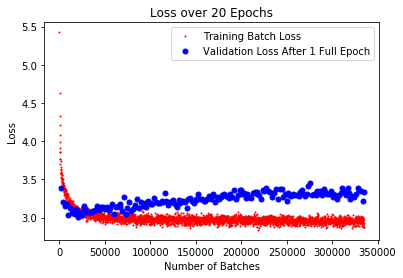

In [40]:
train_trial_number = sorted(output_train_data.keys())
train_trial_loss = [output_train_data[i] for i in train_trial_number]
val_trial_number = sorted(output_val_data.keys())
val_trial_loss = [output_val_data[i] for i in val_trial_number]


plt.plot(train_trial_number, train_trial_loss, 'ro', markersize=1, label='Training Batch Loss')
plt.plot(val_trial_number, val_trial_loss, 'bo', markersize=5, label='Validation Loss After 1 Full Epoch')

plt.xlabel('Number of Batches')
plt.ylabel('Loss')
plt.title('Loss over ' + str(end_epoch) + ' Epochs')
plt.legend()
plt.show()

## Generating Captions

In [46]:
beam_size = 10
batched_temp_data = batch_data(train_data, 1, progress_bar=False)
temp_data_loader = get_loader(train_data, batched_temp_data, word_vocab, topic_vocab, transform, True, 2)
for images, topics, captions, lengths, ids in temp_data_loader:
    json = paragraphs_json[image_ids[ids[0]]]
    DisplayImage(json['url'])
    print(json['url'])
    print("actual caption is: ")
    for sentence in sent_detector.tokenize(json['paragraph']):
        print(sentence.strip().lower())
        
    if torch.cuda.is_available():
        images = images.cuda()
        topics = topics.cuda()
    features = encoder_cnn(images)
    
    results = decoder_rnn.sample(features, topics, beam_size)
    #print("predicted captions for topic %s: " %(topic_vocab(topics.data.select(0, 0))))
    for result in results:
        candidate = [word_vocab(i) for i in result[1][:-1]]
        print(candidate)
    random_topic = torch.LongTensor([random.randint(0, len(topic_vocab) - 1)])
    if torch.cuda.is_available():
        random_topic = random_topic.cuda()
    print("testing changing topic to %s:" %(topic_vocab(random_topic.data.select(0, 0))))
    results = decoder_rnn.sample(features, random_topic, beam_size)
    for result in results:
        candidate = [word_vocab(i) for i in result[1][:-1]]
        print(candidate)
    break

https://cs.stanford.edu/people/rak248/VG_100K/2354514.jpg
actual caption is: 
a man is taking a picture of two women.
the man is using a canon brand camera based on the camera band.
he is also wearing a sleeveless shirt that is blue and white.
the two women are tennis players.
they are conversing with each other.
the one woman is wearing an orange cap and white outfit.
the other woman has dark brown hair with a black headband, seemingly wearing an identical outfit to the other woman.
the dark haired woman is also holding an orange tennis rackets.
behind the women is a green and white sign.
the sign seems to be mounted onto a short blue wall.
behind the wall are grey metal seats, and next to the seats a column of stairs.
[2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2,

Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f91c3d7ca50>> ignored


KeyError: '<UNK>'

## Save the Output Data

In [30]:
with open("data/outputs/{}/train_{}.pkl".format(basedir, num_epochs), "wb") as f:
    pickle.dump(output_train_data, f)
with open("data/outputs/{}/val_{}.pkl".format(basedir, num_epochs), "wb") as f:
    pickle.dump(output_val_data, f)
with open("data/outputs/{}/bleu_{}.pkl".format(basedir, num_epochs), "wb") as f:
    pickle.dump(bleu_score_data, f)
with open("data/outputs/{}/rouge_{}.pkl".format(basedir, num_epochs), "wb") as f:
    pickle.dump(rouge_score_data, f)
with open("data/outputs/{}/cider_{}.pkl".format(basedir, num_epochs), "wb") as f:
    pickle.dump(cider_score_data, f)
with open("data/outputs/{}/attention_{}.pkl".format(basedir, num_epochs), "wb") as f:
    pickle.dump(attention_val_data, f)

## Loading Custom Images

In [ ]:
image_name = "snow"
topic = torch.LongTensor([10])
image = Image.open("../data/custom/" + image_name + ".jpg").convert('RGB')
images = [transform(image)]
images = torch.stack(images, 0)
if torch.cuda.is_available():
    images = images.cuda()
    topics = topics.cuda()
    
features = encoder_cnn(images)
results = decoder_rnn.sample(features, topics, 10)
print("predicted captions for topic %s: " %(topic_vocab(topics.data.select(0, 0))))
for result in results:
    candidate = [word_vocab(i) for i in result[1][:-1]]
    print(candidate)

## Visualizing Attention

In [ ]:
print(image_ids[(dev_data[3][0])])
print(dev_data)

In [ ]:
"""
image_id = 2331872
# 2346802 is a snow image
epoch = 2
alpha_values = attention_val_data[(epoch, image_id)]
max_alpha = max(alpha_values)
alpha_values = [alpha / max_alpha for alpha in alpha_values]

original_image = Image.open("../data/" + str(image_id) + ".jpg") \
    .convert('L').resize((256, 256), Image.ANTIALIAS).crop((0, 0, 224, 224))

image = Image.open("../data/" + str(image_id) + ".jpg").convert('L')
image = image.resize((256, 256), Image.ANTIALIAS)
image = image.crop((0, 0, 224, 224))
pixels = image.load()
row_pixels = image.size[0] // 14
col_pixels = image.size[1] // 14
for i in range(image.size[0]):    # for every col:
    for j in range(image.size[1]):    # For every row
        alpha = alpha_values[(i // row_pixels) * 14 + j // col_pixels]
        pixels[i, j] = int(alpha * pixels[i, j])
result = Image.blend(image, original_image, 0.2)
result = result.resize((448, 448), Image.ANTIALIAS)
display(result)
"""